# Environment Setup:
This notebook is intended to be run on Google Colab. You may complete the tasks offline, but at your own risk.

## Add dataset shortcut from your Google Account
Because of the size of the datasets, we are providing the files from Google Drive.

To access the provided data, go to [this link](https://drive.google.com/drive/folders/1_5LoxbmWDKPKi91Z_HmQn4TFoTtXnxQM?usp=sharing) and click "COMP4211_dataset->Organise->Add shortcut" to save a shortcut in your Google Drive "My Drive" folder (or any specific path in your google drive)

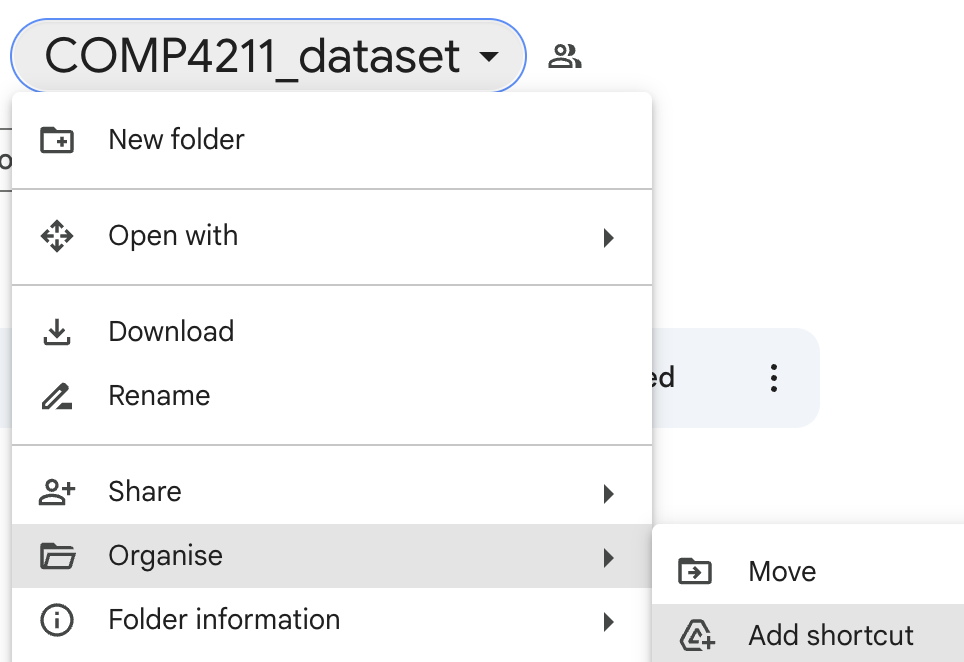

Mount the dataset by the following code (requires authorization):

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)
data_path = "/content/drive/My Drive/COMP4211_dataset"
vgg_path = os.path.join(data_path, 'vgg19.npz')

pacs_zip = os.path.join(data_path, 'classify/pacs-dataset.zip')
wikiart_zip = os.path.join(data_path, 'wikiart.zip')
coco_zip = os.path.join(data_path, 'COCO.zip')

pacs_path = "classify"
wikiart_path = "wikiart"
coco_path = "COCO"


Mounted at /content/drive


To speed up the image loading, we unzip the training image datasets to the Google Colab VM rather than access it directly from Google Drive.

In [2]:
!unzip "$wikiart_zip" > /dev/null 2>&1
!unzip "$coco_zip" > /dev/null 2>&1

(Tip: If you're only doing the second task, skip the above code to save a bit of time)

In [3]:
# Put the PACS files in a subfolder
!mkdir -p "$pacs_path"
!unzip "$pacs_zip" -d "$pacs_path" > /dev/null 2>&1

## Preparation

This section contains imports and functions that will be used in the later tasks. Some of them are provided.

### Imports

In [4]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import array_to_img

# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm.notebook import tqdm
import cv2

# Other utility
import datetime
import psutil

# Module settings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

### Utility Functions

**Preprocessing and Deprocessing Images**: In style transfer, images often need to be adjusted before and after passing through the model. The `preprocess` function converts images from RGB (used in most image formats) to BGR (used by the model) and normalizes pixel values by subtracting a mean value. This step helps in aligning the image data with the format expected by the VGG network, which our style transfer model is based on. Conversely, the `deprocess` function reverses these adjustments, converting the image back from BGR to RGB and adding the mean pixel values, making the output image suitable for viewing.

**Loading Images**: The `get_image` function reads an image from the disk, converts it to the RGB format, and optionally resizes it. This function is crucial for preparing your dataset for training or evaluation. It ensures that all images fed into the model are consistent in size and format.

**Finding Images**: The `find_images` function takes a directory path and a file type, and finds (recursively) all files within the directory that matches the file type. This is used for obtaining the images in the WikiArt and COCO dataset, as the images are put in different folders.

In [5]:
# Prepares an image for the model by converting RGB to BGR and subtracting the mean pixel values.
def preprocess(x):
    img = tf.reverse(x, axis=[-1])  # RGB to BGR
    img -= np.array([103.939, 116.779, 123.68])  # Subtract mean pixel value
    return img

# Converts the output of the model back to a viewable image by adding mean pixel values and converting BGR to RGB.
def deprocess(x):
    img = x + np.array([103.939, 116.779, 123.68])  # Add mean pixel value
    img = tf.reverse(img, axis=[-1])  # BGR to RGB
    img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure pixel value range is valid
    return img

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(256,256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    image = image.astype(np.float32)  # Convert to float32 for model compatibility
    return image

# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths


### Datasets

This programming assignment requires 2 types of dataset, both used for loading images on-demand:

- `ImageDataset`, a dataset class that finds and collects image files within a given directory, and loads them for training. A single sample should only include the image bitmap (preprocessed using the above functions).
- `ClassificationDataset`, a dataset class that references a given `.tsv` file for file names and labels, and loads the images from the given directory along with the class label. A single sample should include the processed image bitmap, along with its class label in one-hot encoding.

In [15]:
# [C1]
class ImageDataset:
    def __init__(self, dir_path, batch_size=8, file_type="jpg", random_state = 4211):
        # [Your code here]
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.file_type = file_type
        self.random_state = random_state

        self.ds_pointer = 0
        self.file_paths = find_images(self.dir_path, self.file_type)

    def reset_pointer(self, seed=None):
        # [Your code here]
        self.ds_pointer = 0
        if seed != None:
            np.random.seed(seed)
        else:
            np.random.seed(self.random_state)
        np.random.shuffle(self.file_paths)
        return

    def get_batch(self):
        # [Your code here]
        #Check if the current pointer is larger than the total number of file_paths
        if (self.ds_pointer + self.batch_size) >= len(self.file_paths):
            self.reset_pointer()
        remaining_samples = len(self.file_paths) - self.ds_pointer

        #Check if the remaining samples is enough
        if remaining_samples < self.batch_size:
            self.reset_pointer()
        batch_files = self.file_paths[self.ds_pointer : (self.ds_pointer + self.batch_size)]
        self.ds_pointer += self.batch_size

        #Create a list of batch images
        batch_images = []
        for file in batch_files:
            batch_images.append(get_image(file))

        #Preprocess the chosen images
        preprocessed_images = []
        for image in batch_images:
            preprocessed_images.append(preprocess(image))

        return np.array(preprocessed_images)

    def __len__(self):
        # [Your code here]
        return len(self.file_paths)

In [16]:
obj = ImageDataset(coco_path)

obj.__len__()

3557

In [17]:
obj2 = ImageDataset(wikiart_path)

obj2.__len__()

7492

In [18]:
# Here's a preview of what the TSV would look like (top 10 rows):
!cat "$pacs_path/train-data.tsv" | head -n 10

pic_2524.jpg	sketch	dog
pic_888.jpg	sketch	dog
pic_1279.jpg	sketch	dog
pic_2694.jpg	sketch	dog
pic_79.jpg	sketch	dog
pic_650.jpg	sketch	dog
pic_2095.jpg	sketch	dog
pic_481.jpg	sketch	dog
pic_332.jpg	sketch	dog
pic_1417.jpg	sketch	dog


In [298]:
# [C2]
class ClassificationDataset:
    def __init__(self, tsv_path, dir_path, batch_size=8, random_state = 4211):
        # [Your code here]
        self.tsv_path = tsv_path
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.random_state = random_state
        self.ds_pointer = 0
        self.file_paths = []
        self.num_class = 0
        self.df = self._process_tsv(tsv_path, dir_path)
        self.columns_for_labels = [col for col in self.df.columns if col.startswith('label_')]

    # Tip: It is recommended to use this method to process the tsv data into a data table, since this will be used in both __init__() and add_data().
    def _process_tsv(self, tsv_path, dir_path):
        df = pd.read_csv(tsv_path, delimiter='\t', names = ['image', 'style', 'label'])

        #print(df)

        #create a df for onehot labels
        after_OH = pd.get_dummies(pd.Series(df['label']), prefix ='label')
        after_OH = pd.DataFrame(after_OH)
        self.num_class = after_OH.shape[1]
        #print(num_class)

        #print(after_OH)

        combined_df = pd.concat([df, after_OH], axis = 1)
        #combined_df = combined_df.drop(columns = 'label')

        #print(combined_df)
        for name in combined_df['image']:
            combined_df.loc[df['image'] == name, 'image'] = os.path.join(dir_path, name)
            self.file_paths.append(os.path.join(dir_path, name))

        combined_df = pd.DataFrame(combined_df, columns=combined_df.columns)

        return combined_df

    def add_data(self, tsv_path, dir_path):
        # [Your code here]
        new_data = pd.read_csv(tsv_path, delimiter='\t', names = ['image', 'style', 'label'])

        for name in new_data['image']:
            new_data.loc[new_data['image'] == name, 'image'] = os.path.join(dir_path, name)

        orig_data = self.df.iloc[0:,0:3]
        new_df = pd.concat([orig_data, new_data], axis=0).reset_index(drop=True)

        after_OH = pd.get_dummies(pd.Series(new_df['label']), prefix ='label')
        after_OH = pd.DataFrame(after_OH)
        self.num_class = after_OH.shape[1]
        #print(self.num_class)

        combined_df = pd.concat([new_df, after_OH], axis = 1)
        combined_df = pd.DataFrame(combined_df, columns=combined_df.columns)

        self.df = combined_df
        #print(self.df)
        self.columns_for_labels = [col for col in self.df.columns if col.startswith('label_')]
        #print(self.columns_for_labels)
        self.num_class = len(self.columns_for_labels)
        #print(self.num_class)

        self.reset_pointer(self.random_state)

    def reset_pointer(self, seed=None):
        # [Your code here]
        self.ds_pointer = 0
        if seed != None:
            np.random.seed(seed)
        indices = self.df.index.to_numpy()
        np.random.shuffle(indices)
        shuffled_df = self.df.iloc[indices].reset_index(drop=True)
        self.df = shuffled_df
        return

    def get_batch(self):
        # [Your code here]

        columns_for_labels = [col for col in self.df.columns if col.startswith('label_')]
        if (self.ds_pointer + self.batch_size) >= len(self.file_paths):
          self.reset_pointer()
        remaining_samples = len(self.file_paths) - self.ds_pointer

        #Check if the remaining samples is enough
        if remaining_samples < self.batch_size:
            self.reset_pointer(self.random_state)
        batch_files = self.df[self.ds_pointer : (self.ds_pointer + self.batch_size)]

        labels_OH = batch_files.iloc[0:self.batch_size,3:]
        label_name = batch_files.iloc[0:self.batch_size,2]
        self.ds_pointer += self.batch_size

        #Create a list of batch images
        batch_images = []
        for file in batch_files['image']:
            batch_images.append(get_image(file))

        #Preprocess the chosen images
        preprocessed_images = []
        for image in batch_images:
            preprocessed_images.append(preprocess(image))

        return np.array(preprocessed_images), labels_OH.to_numpy()

    def __len__(self):
        # [Your code here]
        return len(self.df)

In [299]:
BATCH_SIZE = 64
TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
TEST_DS_PATH = os.path.join(pacs_path, "test-files/")
TEST_TSV_PATH = os.path.join(pacs_path, "test-data.tsv")

train_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
test_ds = ClassificationDataset(TEST_TSV_PATH, TEST_DS_PATH, batch_size = BATCH_SIZE)
#print(train_ds.get_batch())
#print(test_ds.get_batch())
print(f"Length of PACS Training Dataset: {train_ds.__len__()}")
print(f"Length of PACS Test Dataset: {test_ds.__len__()}")

Length of PACS Training Dataset: 1641
Length of PACS Test Dataset: 2723


## Part 1: Style Transfer


### Model Components

In [174]:
class AdaIN(Layer):
    """
    Adaptive Instance Normalization (AdaIN) layer with controllable style transfer intensity.
    This layer adjusts the mean and variance of the content features to match those of the style features,
    then blends the result with the original content features based on a specified alpha value.
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.epsilon = epsilon  # Small constant to avoid division by zero.

    def call(self, inputs):
        content, style, alpha = inputs

        # Compute mean and variance for content and style features.
        meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True)
        meanS, varS = tf.nn.moments(style, [1, 2], keepdims=True)

        # Standard deviation is the square root of variance, adjusted with epsilon for numerical stability.
        sigmaC = tf.sqrt(varC + self.epsilon)
        sigmaS = tf.sqrt(varS + self.epsilon)

        # Perform AdaIN by normalizing content features and scaling them by style's standard deviation and mean.
        normalized_content = (content - meanC) / sigmaC
        stylized_content = normalized_content * sigmaS + meanS

        # Blend stylized content with original content based on alpha.
        blended_content = alpha * stylized_content + (1 - alpha) * content
        return blended_content

In [22]:
def build_vgg19_enc(input_shape, weights_path):
    weights = np.load(weights_path)

    # [C3] Create vgg19 structure
    model = tf.keras.Sequential() # [Your code here]

    #conv1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv1_1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv1_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))

    #conv2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv2_1'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv2_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2'))

    #conv3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv3_1'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv3_2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv3_3'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv3_4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3'))

    #conv4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv4_1'))

    # [C4] Load in weights and freeze the model
    # [Your code here]
    weights = np.load(weights_path)
    index = 0

    for layer in model.layers:
        if isinstance(layer, Conv2D):
            kernel = weights[f'arr_{index}']
            bias = weights[f'arr_{index + 1}']

            kernel = kernel.transpose([2, 3, 1, 0])

            #to ensure compatibility with TensorFlow model
            if kernel.dtype != np.float32:
                kernel = kernel.astype(np.float32)
            if bias.dtype != np.float32:
                bias = bias.astype(np.float32)

            #load prepared kernel and bias to the model layer
            layer.set_weights([kernel, bias])
            index += 2

    #freeze the weights during training
    model.trainable = False

    return model

def build_vgg19_relus(vgg19):
    relus = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
    features = [vgg19.get_layer(relu).output for relu in relus]
    vgg19_relus = Model(inputs=vgg19.input, outputs=features)
    vgg19_relus.trainable = False
    return vgg19_relus

# [C5]
def build_decoder(input_shape):
    model = tf.keras.Sequential()

    #upsampling1
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(UpSampling2D(size=(2, 2)))

    #upsampling2
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(UpSampling2D(size=(2, 2)))

    #upsampling3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(UpSampling2D(size=(2, 2)))

    #upsampling4
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(3, (3, 3), padding='same', input_shape=input_shape))

    return model # [Your code here]


def build_model(encoder, decoder, input_shape):
    content = Input(shape=input_shape, name='content')
    style = Input(shape=input_shape, name = 'style')
    alpha = Input(shape=(1,), name='alpha')

    enc_content = encoder(content)
    enc_style = encoder(style)

    adain = AdaIN()([enc_content, enc_style, alpha])

    out = decoder(adain)

    return Model(inputs=[content, style, alpha], outputs=[out, adain])


In [23]:
def get_loss(encoder, vgg19_relus, epsilon=1e-5, style_weight=1.0):

    def loss(y_true, y_pred):
        out, adain = y_pred[0], y_pred[1]

        # Encode output and compute content_loss
        out = deprocess(out)
        out = preprocess(out)
        enc_out = encoder(out)
        content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(enc_out - adain), axis=[1, 2]))

        # Compute style loss from vgg relus
        style = y_true[1]
        style_featues = vgg19_relus(style)
        gen_features = vgg19_relus(out)
        style_layer_loss = []
        for enc_style_feat, enc_gen_feat in zip(style_featues, gen_features):
            meanS, varS = tf.nn.moments(enc_style_feat, [1, 2])
            meanG, varG = tf.nn.moments(enc_gen_feat,   [1, 2])

            sigmaS = tf.sqrt(varS + epsilon)
            sigmaG = tf.sqrt(varG + epsilon)

            l2_mean  = tf.reduce_sum(tf.square(meanG - meanS))
            l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

            style_layer_loss.append(l2_mean + l2_sigma)

        style_loss = tf.reduce_sum(style_layer_loss)

        # Compute the total loss
        weighted_style_loss = style_weight * style_loss
        total_loss = content_loss + weighted_style_loss
        return total_loss, content_loss, weighted_style_loss

    return loss

### Training Routine

In [24]:
# [C6]
def part1_train(model, content_ds, style_ds, loss_fn, n_epochs = 10, save_interval = 10, save_path=None, load_path=None):
    # Initialize the Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, weight_decay = 5e-5) # [Your code here]

    # Calculate the number of batches per epoch
    n_batches = int(np.ceil(len(content_ds) / content_ds.batch_size)) # [Your code here]

    # Initialize other things
    process = psutil.Process(os.getpid())
    alpha = 1.0

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        # [Your code here]
        content_ds.reset_pointer()
        style_ds.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"total": 0.0, "content": 0.0, "style": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            # [Your code here]
            contents = content_ds.get_batch()
            styles = style_ds.get_batch()

            # Execute Batch Training
            # Tip: Use tf.GradientTape() when computing the loss, to obtain the gradient.
            # [Your code here]
            with tf.GradientTape() as tp:

                #pass the content and style image (along with an alpha value)
                out, adain = model([contents, styles, alpha])

                #pass the output to the loss function
                total_loss, content_loss, style_loss = loss_fn([contents, styles], [out, adain])

            gradient = tp.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradient, model.trainable_variables))

            # Update Loss Metrics
            # [Your code here]
            losses["total"] = (losses["total"] * i + total_loss)/(i+1)
            losses["content"] = (losses["content"] * i + content_loss)/(i+1)
            losses["style"] = (losses["style"] * i + style_loss)/(i+1)

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform a save on the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)

### Model setup

In [25]:
def part1_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 16 # Recommended according to the Google Colab T4 GPU

    content_ds = ImageDataset(coco_path, batch_size=BATCH_SIZE)
    style_ds = ImageDataset(wikiart_path, batch_size=BATCH_SIZE)

    return content_ds, style_ds

def part1_setup():
    #####
    # MODIFY SETTINGS HERE
    #####
    STYLE_WEIGHT = 1.0
    EPSILON = 1e-5

    INPUT_SHAPE = (None, None, 3) # We accept any image size

    # Build model
    vgg19 = build_vgg19_enc(INPUT_SHAPE, vgg_path)  # encoder
    decoder = build_decoder(vgg19.output.shape[1:])  # input shape == encoder output shape
    model = build_model(vgg19, decoder, INPUT_SHAPE)

    # Get loss
    vgg19_relus = build_vgg19_relus(vgg19)
    loss = get_loss(vgg19, vgg19_relus, epsilon=EPSILON, style_weight=STYLE_WEIGHT)

    return model, loss

In [26]:
content_ds, style_ds = part1_prepare_datasets()

In [27]:
model, loss = part1_setup()

In [28]:
PART1_SAVE_PATH = "/content/drive/MyDrive/COMP_4211/saved.h5"

We can now start the training:

In [29]:
#####
# We recommend you to save on your mounted Google Drive folder,
# otherwise it may get lost after the Colab session terminated
#####
PART1_SAVE_PATH = "/content/drive/MyDrive/COMP_4211/saved.h5" # Change to your own path.

part1_train(model, content_ds, style_ds, loss, n_epochs=15, save_path=PART1_SAVE_PATH)

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

In [30]:
model.save("/content/drive/MyDrive/COMP_4211/saved.h5")

In [ ]:
# To continue to train the saved weights, do this:
PART1_LOAD_PATH = '/content/drive/MyDrive/COMP_4211/saved.h5' # Change to your own path

part1_train(model, content_ds, style_ds, loss, n_epochs=5, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH)

Note: Due to the limited computing time available in Colab, it may be a good idea to divide the training into different sessions, by saving and loading the model weights in your Google Drive.  

Do not save the weights outside the drive or they will be deleted after the session ends!

### Inference

In [31]:
# [C7]
def part1_inference(model_path, content_path, style_path, alpha):
    model = load_model(model_path, custom_objects={'AdaIN': AdaIN})

    # Get content image
    # [Your code here]
    images = get_image(content_path)
    preprocessed_images = preprocess(images)
    preprocessed_images = np.expand_dims(preprocessed_images, axis=0)

    # Get style image
    # [Your code here]
    styles = get_image(style_path)
    style_image = preprocess(styles)
    style_image = np.expand_dims(style_image, axis=0)

    # Set alpha Value
    # [Your code here]
    alpha_value = tf.constant(alpha, dtype = tf.float32)
    alpha_value = tf.expand_dims(alpha_value, axis=0)

    # Do inference
    # [Your code here]
    generated_img = model.predict([preprocessed_images, style_image, alpha_value])

    # Convert output array to image
    # [Your code here]
    if isinstance(generated_img, list) and len(generated_img) > 0:
        generated_img = generated_img[0]

    generated_img = np.array(generated_img)
    processed_img = deprocess(generated_img.squeeze())

    img = array_to_img(processed_img)

    # Display the image in the Notebook
    display(img)

1/1 [==============================] - 2s 2s/step


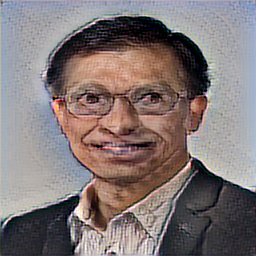

In [32]:
#####
# MODIFY SETTINGS HERE
#####
ALPHA = 0.75
MODEL_PATH = PART1_SAVE_PATH
# Here below is a sample, please change to your own path
CONTENT_PATH = os.path.join(data_path, 'HKUST/dyyeung.jpg')
# Here below is a sample, please change to your own path
STYLE_PATH = os.path.join(data_path, '/content/wikiart/Analytical_Cubism/juan-gris_portrait-of-maurice-raynal-1911.jpg')

part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

1/1 [==============================] - 0s 279ms/step


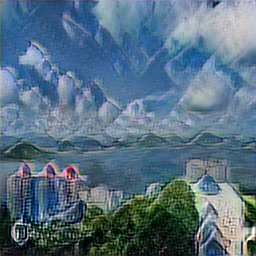

In [33]:
# Another sample, please change and test on your own
ALPHA=0.75
CONTENT_PATH = os.path.join(data_path, 'HKUST/7.jpeg')
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = os.path.join(data_path, 'Extra_styles/the-starry-night.jpg')
part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

## Part 2: Classification Task

The second part of this assignment is a Classification Task, but with an unideal training dataset.

This task uses the PACS dataset (an image dataset with images of different categories and in different styles), but modified to have an abnormal distribution between styles and categories.

### Analyzing the dataset

Before we start the classification task, let's load and obtain some basic info about our training dataset.

In [240]:
def part2_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    TEST_DS_PATH = os.path.join(pacs_path, "test-files/")
    TEST_TSV_PATH = os.path.join(pacs_path, "test-data.tsv")

    train_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    test_ds = ClassificationDataset(TEST_TSV_PATH, TEST_DS_PATH, batch_size = BATCH_SIZE)

    return train_ds, test_ds

train_ds, test_ds = part2_prepare_datasets()

Find out the distribution of images in diferent styles and categories:

In [241]:
# [C8]
def part2_tally_samples(dataset):
    # [Your code here]
    count_df = dataset.df.groupby(['style', 'label']).size().reset_index(name = 'count')
    print(count_df)

part2_tally_samples(train_ds)

           style     label  count
0   art_painting       dog     13
1   art_painting  elephant     13
2   art_painting   giraffe    231
3   art_painting    guitar     10
4   art_painting     horse    180
5   art_painting     house     11
6   art_painting    person     11
7        cartoon       dog     10
8        cartoon  elephant     13
9        cartoon   giraffe     12
10       cartoon    guitar    121
11       cartoon     horse     11
12       cartoon     house     12
13       cartoon    person     12
14         photo       dog     10
15         photo  elephant     13
16         photo   giraffe     12
17         photo    guitar     10
18         photo     horse     11
19         photo     house    215
20         photo    person    211
21        sketch       dog    229
22        sketch  elephant    217
23        sketch   giraffe     10
24        sketch    guitar      9
25        sketch     horse      8
26        sketch     house     13
27        sketch    person     13


Compare this to the test dataset:

In [242]:
part2_tally_samples(test_ds)

           style     label  count
0   art_painting       dog    119
1   art_painting  elephant     89
2   art_painting   giraffe    110
3   art_painting    guitar     82
4   art_painting     horse     90
5   art_painting     house    110
6   art_painting    person     96
7        cartoon       dog     95
8        cartoon  elephant     83
9        cartoon   giraffe    109
10       cartoon    guitar     82
11       cartoon     horse     81
12       cartoon     house    101
13       cartoon    person     95
14         photo       dog     81
15         photo  elephant     83
16         photo   giraffe    102
17         photo    guitar     81
18         photo     horse    103
19         photo     house     95
20         photo    person    110
21        sketch       dog    112
22        sketch  elephant    115
23        sketch   giraffe    104
24        sketch    guitar     95
25        sketch     horse    108
26        sketch     house     80
27        sketch    person    112


### Main Implementation

The architecture of the classification model is also a VGG19 model, adapted for multiclass classification.

In [243]:
# [C9]
def build_vgg19_classifier(input_shape, num_class):
    # Create vgg19 structure
    # [Your code here]
    model = tf.keras.Sequential()

    #conv1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv1_1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv1_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))

    #conv2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv2_1'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv2_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2'))

    #conv3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv3_1'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv3_2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv3_3'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv3_4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3'))

    #conv4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv4_1'))

    model.add(GlobalAveragePooling2D(name='global_pool'))
    model.add(Dense(1024, activation='relu', name='dense1'))
    model.add(Dense(1024, activation='relu', name='dense2'))
    model.add(Dense(512, activation='relu', name='dense3'))
    model.add(Dense(num_class, activation='softmax', name='dense4'))

    return model

In [244]:
# [This part is not graded but is required for successful completion of other tasks]
def part2_setup(LOAD_PATH = None):
    INPUT_SHAPE = (None, None, 3)

    # Build model
    NUM_CLASS = train_ds.num_class
    model = build_vgg19_classifier(INPUT_SHAPE, NUM_CLASS) # [Your code here]

    # Get Loss
    loss_fn = tf.keras.losses.CategoricalCrossentropy()# [Your code here]

    if LOAD_PATH:
        model.load_weights(LOAD_PATH)

    return model, loss_fn

model2, loss2 = part2_setup()

### Training the model with the given dataset

In [245]:
# [C10]
def part2_train(model, dataset, loss_fn, n_epochs = 100, save_interval = 10, save_path=None, load_path=None):
    # Initialize the Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, weight_decay = 5e-5) # [Your code here]

    # Calculate the number of batches per epoch
    n_batches = int(np.ceil(dataset.__len__() / dataset.batch_size)) # [Your code here]

    # Initialize other things
    process = psutil.Process(os.getpid())

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        # [Your code here]
        dataset.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"cross-entropy": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            # [Your code here]
            image_pixels, labels = dataset.get_batch()

            # Execute Batch Training
            # [Your code here]
            with tf.GradientTape() as tp:

                #pass the content and style image (along with an alpha value)
                out = model(image_pixels)
                labels_tensor = tf.convert_to_tensor(labels, dtype = tf.float32)

                #pass the output to the loss function
                loss = loss_fn(labels_tensor, out)

            gradient = tp.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradient, model.trainable_variables))


            # Update Loss Metrics
            # [Your code here]
            losses['cross-entropy'] = ((losses['cross-entropy']*i)+loss)/(i+1)

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform save the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)


In [ ]:
# Train the model
PART2_SAVE_PATH = "/content/drive/MyDrive/COMP_4211/PART_2/classify.h5" # [Change to your own path]

# [Call your train function here]
part2_train(model2, train_ds, loss2, n_epochs = 100, save_interval = 10, save_path=PART2_SAVE_PATH, load_path=None)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [297]:
model2 = load_model("/content/drive/MyDrive/COMP_4211/PART_2/classify.h5")
PART2_SAVE_PATH = "/content/drive/MyDrive/COMP_4211/PART_2/classify.h5" # [Change to your own path]

# [Call your train function here]
part2_train(model2, train_ds, loss2, n_epochs = 20, save_interval = 10, save_path="/content/drive/MyDrive/COMP_4211/PART_2/classify.h5", load_path="/content/drive/MyDrive/COMP_4211/PART_2/classify.h5")

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

### Testing

We can now test our first classifier model with the test dataset (maybe train dataset too, to make sure the training went properly).

Calculate the accuracy of the model, as well as the confusion matrix to for a clearer idea on the model's performance:

In [292]:
# [C11]
from sklearn.metrics import confusion_matrix, accuracy_score
def part2_evaluate(model, dataset):
    # [Your code here]
    expected = []
    predictions = []

    for j in range(dataset.__len__()//dataset.batch_size):
        images, labels = dataset.get_batch()
        listoflabels = []
        predicted = model(images)
        predicted_classes = np.argmax(predicted, axis = 1)


        expected_labels = np.argmax(labels, axis = 1)
        expected.extend(expected_labels)
        predictions.extend(predicted_classes)

    accuracy = accuracy_score(expected, predictions)

    conf_matrix = np.zeros((dataset.num_class, dataset.num_class), dtype=int)
    for x,y in zip(expected, predictions):
        conf_matrix[x][y] += 1

    return accuracy, conf_matrix

In [295]:
model2 = load_model("/content/drive/MyDrive/COMP_4211/PART_2/classify.h5")

In [296]:
accuracy2, confusion_matrix2 = part2_evaluate(model2, train_ds)
print("For Training Dataset")
print(f"Accuracies: {accuracy2}")
print(f"Confusion Matrix: \n {confusion_matrix2}")

accuracy, confusion_matrix = part2_evaluate(model2, test_ds)
print("For Test Dataset")
print(f"Accuracies: {accuracy}")
print(f"Confusion Matrix: \n {confusion_matrix}")

For Training Dataset
Accuracies: 0.91375
Confusion Matrix: 
 [[196  47   3   1   7   1   1]
 [  9 237   0   0   1   1   0]
 [  6   0 248   2   5   0   0]
 [  2   0   8 128   8   0   0]
 [  2   2   3   0 199   0   0]
 [  2   1   7   0   5 226   0]
 [  8   0   2   0   3   1 228]]
For Test Dataset
Accuracies: 0.45498511904761907
Confusion Matrix: 
 [[ 92  59  90  18 121   9  12]
 [ 31 175  66   9  61   9  15]
 [ 63  19 243  33  28  24   9]
 [ 23  12  42 168  73   4  14]
 [ 90  32  43  14 173  12  14]
 [  5  10 108  12  40 204   4]
 [ 50  20  79   9  58  21 168]]


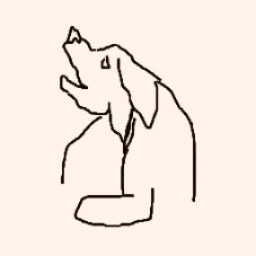

Actual Label: dog
Predicted Label: [1]
Label Names: ['label_dog', 'label_elephant', 'label_giraffe', 'label_guitar', 'label_horse', 'label_house', 'label_person']




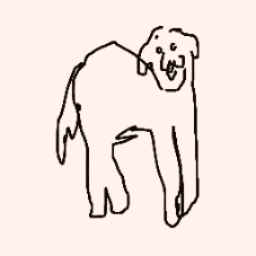

Actual Label: dog
Predicted Label: [1]


In [249]:
img_path = train_ds.df.iloc[1,0]
label = train_ds.df.iloc[1,2]
display(array_to_img(preprocess(get_image(img_path))))
print(f"Actual Label: {train_ds.df['label'][1]}")
image_array = (preprocess(get_image(img_path)))
image_batch = np.expand_dims(image_array, axis=0)
print(f"Predicted Label: {np.argmax(model(image_batch), axis = 1)}")
print(f"Label Names: {train_ds.columns_for_labels}")
print()
print()

img_path = train_ds.df.iloc[7,0]
label = train_ds.df.iloc[7,2]
display(array_to_img(preprocess(get_image(img_path))))
print(f"Actual Label: {train_ds.df['label'][7]}")
image_array = (preprocess(get_image(img_path)))
image_batch = np.expand_dims(image_array, axis=0)
print(f"Predicted Label: {np.argmax(model(image_batch), axis = 1)}")

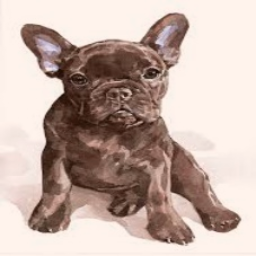

Actual Label: dog
Predicted Label: [4]
Label Names: ['label_dog', 'label_elephant', 'label_giraffe', 'label_guitar', 'label_horse', 'label_house', 'label_person']




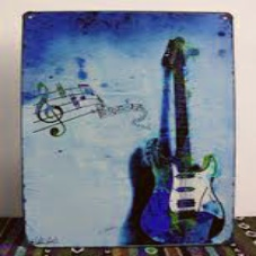

Actual Label: guitar
Predicted Label: [4]




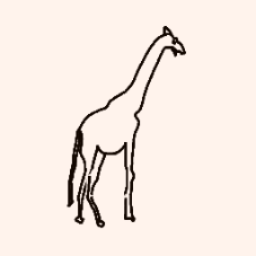

Actual Label: giraffe
Predicted Label: [0]




In [210]:
img_path = test_ds.df.iloc[1,0]
label = test_ds.df.iloc[1,2]
display(array_to_img(preprocess(get_image(img_path))))
print(f"Actual Label: {test_ds.df['label'][1]}")
image_array = (preprocess(get_image(img_path)))
image_batch = np.expand_dims(image_array, axis=0)
print(f"Predicted Label: {np.argmax(model(image_batch), axis = 1)}")
print(f"Label Names: {test_ds.columns_for_labels}")
print()
print()

img_path = test_ds.df.iloc[387,0]
label = test_ds.df.iloc[387,2]
display(array_to_img(preprocess(get_image(img_path))))
print(f"Actual Label: {test_ds.df['label'][387]}")
image_array = (preprocess(get_image(img_path)))
image_batch = np.expand_dims(image_array, axis=0)
print(f"Predicted Label: {np.argmax(model(image_batch), axis = 1)}")
print()
print()

img_path = test_ds.df.iloc[964,0]
label = test_ds.df.iloc[964,2]
display(array_to_img(preprocess(get_image(img_path))))
print(f"Actual Label: {test_ds.df['label'][964]}")
image_array = (preprocess(get_image(img_path)))
image_batch = np.expand_dims(image_array, axis=0)
print(f"Predicted Label: {np.argmax(model(image_batch), axis = 1)}")
print()
print()

### Data Augmentation with Style Transfer

In [250]:
# [C12]
def part2_transfer(model, dataset, content_idx, style_idx, alpha):
    # [Your code here]
    # Tip: A large part of part1_inference can be applied here.

    model = model

    # Get content image
    images = get_image(dataset.df.iloc[content_idx][0])
    preprocessed_images = preprocess(images)
    preprocessed_images = np.expand_dims(preprocessed_images, axis=0)

    # Get style image
    styles = get_image(dataset.df.iloc[style_idx][0])
    style_image = preprocess(styles)
    style_image = np.expand_dims(style_image, axis=0)

    # Set alpha Value
    alpha_value = tf.convert_to_tensor([alpha])
    alpha_value = tf.expand_dims(alpha_value, axis=0)

    # Do inference
    generated_img = model.predict([preprocessed_images, style_image, alpha_value])

    # Convert output array to image
    if isinstance(generated_img, list) and len(generated_img) > 0:
        generated_img = generated_img[0]

    generated_img = np.array(generated_img)
    processed_img = deprocess(generated_img.squeeze())

    img = array_to_img(processed_img)

    # Instead of displaying the image, return it to be saved:
    return img

In [266]:
# [C12]
def part2_augment(part1_load_path, dataset, output_tsv, output_dir, samples_per_pair = 50, alpha = ALPHA, random_state = 4211):
    # We don't want to reload the model for every single sample,
    # so we load one here and pass it to the transfer function:
    model = load_model(part1_load_path, custom_objects={'AdaIN': AdaIN}) # [Your code here]

    # Get label and style samples to transfer from
    # These are expected to be in the form of
    # { "(label/style name)": [(list of indices in the dataset that corresponds to the label/style)], ... }
    # Tip: If you can have a pandas Dataframe from the dataset, you can use groupby(...).indices here.
    df_label = dataset.df.groupby("label")
    df_style = dataset.df.groupby("style")
    labeldict = df_label.indices # [Your code here]
    styledict = df_style.indices # [Your code here]

    # Generate random samples
    rng = np.random.default_rng(random_state)
    derived_tsv = "" # For usage in ClassificationDataset
    pair_set = set() # To prevent generating duplicates
    for label, label_idxs in labeldict.items():
        for style, style_idxs in styledict.items():
            for _ in range(samples_per_pair):
                pair = None
                while not pair or pair in pair_set:
                    pair = rng.choice(label_idxs), rng.choice(style_idxs)
                pair_set.add(pair)

                # Generate 1 sample
                img = part2_transfer(model, dataset, pair[0], pair[1], alpha)

                # Make up a name for the same sample. Don't repeat the names!
                derived_name = f"{label}_{style}_{_}.jpg" # [Your code here]
                # Add an entry to the TSV file. Follow the format of "train-data.tsv" and "test-data.tsv"!
                derived_entry = f"{derived_name}\t{style}\t{label}\n" # [Your code here]

                # Save the image in the given folder
                img.save(os.path.join(output_dir, derived_name))
                # Add entry to the TSV to be written
                derived_tsv += derived_entry

    # Write the entries into the given file name
    with open(output_tsv, "w") as f:
        f.write(derived_tsv)


In [267]:
PART1_MODEL_PATH = "/content/drive/MyDrive/COMP_4211/saved.h5" # [Change to your part_1 saved weight]
ALPHA = 0.75

OUTPUT_TSV = "classify/derived-data.tsv"
OUTPUT_DIR = "classify/derived-files"

# Before running the augmentation, it is a good idea to prepare an empty directory for the generated outputs:
def part2_cleanup_augments(output_dir):
    !rm -rf "$output_dir"
    !mkdir -p "$output_dir"

In [268]:
!cat "$OUTPUT_TSV"

dog_art_painting_0.jpg 	 art_painting 	 dog 
dog_art_painting_1.jpg 	 art_painting 	 dog 
dog_art_painting_2.jpg 	 art_painting 	 dog 
dog_art_painting_3.jpg 	 art_painting 	 dog 
dog_art_painting_4.jpg 	 art_painting 	 dog 
dog_art_painting_5.jpg 	 art_painting 	 dog 
dog_art_painting_6.jpg 	 art_painting 	 dog 
dog_art_painting_7.jpg 	 art_painting 	 dog 
dog_art_painting_8.jpg 	 art_painting 	 dog 
dog_art_painting_9.jpg 	 art_painting 	 dog 
dog_art_painting_10.jpg 	 art_painting 	 dog 
dog_art_painting_11.jpg 	 art_painting 	 dog 
dog_art_painting_12.jpg 	 art_painting 	 dog 
dog_art_painting_13.jpg 	 art_painting 	 dog 
dog_art_painting_14.jpg 	 art_painting 	 dog 
dog_art_painting_15.jpg 	 art_painting 	 dog 
dog_art_painting_16.jpg 	 art_painting 	 dog 
dog_art_painting_17.jpg 	 art_painting 	 dog 
dog_art_painting_18.jpg 	 art_painting 	 dog 
dog_art_painting_19.jpg 	 art_painting 	 dog 
dog_cartoon_0.jpg 	 cartoon 	 dog 
dog_cartoon_1.jpg 	 cartoon 	 dog 
dog_cartoon_2.jpg 	 

In [269]:
# Generate the dataset:
part2_cleanup_augments(OUTPUT_DIR)
part2_augment(PART1_MODEL_PATH, train_ds, OUTPUT_TSV, OUTPUT_DIR, samples_per_pair = 20, alpha = ALPHA, random_state = 4211)

1/1 [==============================] - 0s 23ms/step


### Training the model with an augmented dataset

After generating the images we can produce a new, augmented dataset for retraining. We would like to add the data to the existing train dataset, in order to have a more balanced distribution between different styles and categories.

In [287]:
def part2_prepare_aug_dataset():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    DERIVED_DS_PATH = os.path.join(pacs_path, "derived-files/")
    DERIVED_TSV_PATH = os.path.join(pacs_path, "derived-data.tsv")

    train2_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    train2_ds.add_data(DERIVED_TSV_PATH, DERIVED_DS_PATH)

    return train2_ds

train2_ds = part2_prepare_aug_dataset()

We can confirm the augmentation by looking at its distribution:

In [288]:
part2_tally_samples(train2_ds)

           style     label  count
0   art_painting       dog     33
1   art_painting  elephant     33
2   art_painting   giraffe    251
3   art_painting    guitar     30
4   art_painting     horse    200
5   art_painting     house     31
6   art_painting    person     31
7        cartoon       dog     30
8        cartoon  elephant     33
9        cartoon   giraffe     32
10       cartoon    guitar    141
11       cartoon     horse     31
12       cartoon     house     32
13       cartoon    person     32
14         photo       dog     30
15         photo  elephant     33
16         photo   giraffe     32
17         photo    guitar     30
18         photo     horse     31
19         photo     house    235
20         photo    person    231
21        sketch       dog    249
22        sketch  elephant    237
23        sketch   giraffe     30
24        sketch    guitar     29
25        sketch     horse     28
26        sketch     house     33
27        sketch    person     33


Now we can train another classifier using the augmented data:

In [289]:
PART2_SAVE_PATH_2 = "/content/drive/MyDrive/classify-augmentation.h5" # [Change to your own path]

# [Call your train function here, training on train2_ds]
part2_train(model2, train2_ds, loss2, n_epochs = 100, save_interval = 10, save_path=PART2_SAVE_PATH_2, load_path=None)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [290]:
model2 = load_model("/content/drive/MyDrive/classify-augmentation.h5")

In [293]:
accuracy2, confusion_matrix2 = part2_evaluate(model2, train2_ds)
print("For Training Dataset")
print(f"Accuracies: {accuracy2}")
print(f"Confusion Matrix: \n {confusion_matrix2}")

accuracy, confusion_matrix = part2_evaluate(model2, test_ds)
print("For Test Dataset")
print(f"Accuracies: {accuracy}")
print(f"Confusion Matrix: \n {confusion_matrix}")

For Training Dataset
Accuracies: 0.9967830882352942
Confusion Matrix: 
 [[356   2   0   0   0   0   5]
 [  0 322   0   0   0   0   0]
 [  0   0 317   0   0   0   0]
 [  0   0   0 230   0   0   0]
 [  0   0   0   0 283   0   0]
 [  0   0   0   0   0 349   0]
 [  0   0   0   0   0   0 312]]
For Test Dataset
Accuracies: 0.4973958333333333
Confusion Matrix: 
 [[125  29  60  42 111  15  22]
 [ 39 149  65  15  60  12  23]
 [ 57  15 235  35  33  35   8]
 [ 21   6  28 211  41   9  21]
 [ 90  26  35  28 164  23  11]
 [  9   9  74  28  19 228  14]
 [ 19  25  60  22  47  10 225]]


In [294]:
accuracy2, confusion_matrix2 = part2_evaluate(model2, train_ds)
print("For Training Dataset")
print(f"Accuracies: {accuracy2}")
print(f"Confusion Matrix: \n {confusion_matrix2}")

For Training Dataset
Accuracies: 0.9975
Confusion Matrix: 
 [[247   1   0   0   0   0   3]
 [  0 251   0   0   0   0   0]
 [  0   0 259   0   0   0   0]
 [  0   0   0 148   0   0   0]
 [  0   0   0   0 209   0   0]
 [  0   0   0   0   0 243   0]
 [  0   0   0   0   0   0 239]]


Test the model for any performance changes. After that, feel free to explore on more ways to improve the model!